![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

# **Regularisation in PyTorch - Part 2**
### **Now we use a few Regularisation methods on our Fashion-MNIST CNN**

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-12-02%20at%204.01.54%402x.png)
---



---


In this lesson, we first learn to create a **simple Convolutional Neural Network model** in PyTorch and train it to **classify images in the Fashion-MNIST Dataset**, now **WITH** the use of any regularisation methods. 
1. Import PyTorch libraries, define our Transformers, Load our dataset and Visualize our images.
2. Build a Simple CNN with the following **Regularisation** methods:
  - L2 Regularisation
  - Data Augmentation
  - Dropout
  - BatchNorm
3. Training our CNN with Regularisation


# **1. Import PyTorch libraries, Define Transfomers and Load & Visualise Dataset**

In [ ]:
# Import PyTorch
import torch
import PIL
import numpy as np

# We use torchvision to get our dataset and useful image transformations
import torchvision
import torchvision.transforms as transforms

# Import PyTorch's optimization libary and nn
# nn is used as the basic building block for our Network graphs
import torch.optim as optim
import torch.nn as nn

# Are we using our GPU?
print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


In [ ]:
device = 'cuda' #'cpu' if no GPU available

# **2. Building a CNN with Regulisation**
## **Implementing Data Augmentation**

#### **Understanding What Our Transforms Do**

1. Our Transforms are applied to an image or batch of images everytime it's loaded.
2. These new images aren't saved, they're generated or 'altered' everytime a batch is loaded

#### **NOTE** 

We don't apply the same augmentations to our Test or Validation Datasets. Therefore, we keep separate transformation functions (see below) for our Train and Validation/Test data.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        # Note these are executed in the order they are called here
        # Some of these transforms return a color image, hence why we need to convert
        # the image back to grayscale
        transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
        transforms.ColorJitter(hue = .05, saturation = .05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, resample = PIL.Image.BILINEAR),
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
}

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


### **Fetch and Create our Data Loaders**

In [ ]:
# Load our Train Data and specify what transform to use when loading
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])

# Load our Test Data and specify what transform to use when loading
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])

# Prepare train and test loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### **Adding Dropout**

In Convolutional Neural Networks Dropout is commonly added after CONV-RELU Layers.

E.g. CONV->RELU->**DROPOUT**

#### **Dropout Recommendations** 

In CNN's values of 0.1 to 0.3 have been found to work well.

### **Adding BatchNorm**

In CNNs **BatchNorm** is best used between the Conv Layer and the activation function layer (ReLU)
When used with Dropout, the recommended order is: 

CONV_1 -> **BatchNorm** -> ReLU -> Dropout - CONV_2

**NOTE** BatchNorm's input arguement is the **output** size of the previous layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Adding BatchNorm, using 32 as the input since 32 was the output of our first Conv layer
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Adding BatchNorm, using 64 as the input since 64 was the output of our first Conv layer
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        # Defining our dropout function with a rate of 0.2
        # We can apply this after any layer, but it's best suited after ReLU
        self.dropOut = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropOut(x)
        x = self.dropOut(F.relu(self.conv2_bn(self.conv2(x))))

        x = self.pool(x)
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

### **Adding L2 Regularisation**


L2 regularisation on the parameters/weights of the model is directly included in most optimizers, including optim.SGD.

It can be controlled with the **weight_decay** parameter as can be seen in the [SGD documentation](http://pytorch.org/docs/optim.html#torch.optim.SGD).

```weight_decay``` (**float**, optional) – weight decay *(L2 penalty) (default: 0)*

**Good L2 Values range from 0.1 to 0.0001**

**NOTE:**

 L1 regularization is not included by default in the optimizers, but could be added by including an extra loss nn.L1Loss in the weights of the model.



In [ ]:
# We import our optimizer function
import torch.optim as optim

# We use Cross Entropy Loss as our loss function
criterion = nn.CrossEntropyLoss()

# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.001)

# **3. Training Our Model Using Regulisation Methods - Data Augmentation, Dropout, BatchNorm & L2 Regularisation**

In [ ]:
# We loop over the traing dataset multiple times (each time is called an epoch)
epochs = 15

# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):  
    print(f'Starting Epoch: {epoch+1}...')

    # We keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator
    # Each cycle is a minibatch
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move our data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients before training by setting to zero
        # Required for a fresh start
        optimizer.zero_grad()

        # Forward -> backprop + optimize
        outputs = net(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights

        # Print Training statistics - Epoch/Iterations/Loss/Accurachy
        running_loss += loss.item()
        if i % 100 == 99:    # show our loss every 50 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in 
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in testloader:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Foward propagate our test data batch through our model
                    outputs = net(images)

                     # Get predictions from the maximum value
                    _, predicted = torch.max(outputs.data, 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.491, Test Accuracy = 72.950%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.615, Test Accuracy = 71.840%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.475, Test Accuracy = 75.570%
Epoch: 1, Mini-Batches Completed: 400, Loss: 1.361, Test Accuracy = 77.310%
Epoch: 1, Mini-Batches Completed: 500, Loss: 1.360, Test Accuracy = 77.130%
Epoch: 1, Mini-Batches Completed: 600, Loss: 1.246, Test Accuracy = 77.630%
Epoch: 1, Mini-Batches Completed: 700, Loss: 1.274, Test Accuracy = 80.370%
Epoch: 1, Mini-Batches Completed: 800, Loss: 1.221, Test Accuracy = 79.960%
Epoch: 1, Mini-Batches Completed: 900, Loss: 1.199, Test Accuracy = 79.370%
Epoch: 1, Mini-Batches Completed: 1000, Loss: 1.155, Test Accuracy = 80.750%
Epoch: 1, Mini-Batches Completed: 1100, Loss: 1.160, Test Accuracy = 81.360%
Epoch: 1, Mini-Batches Completed: 1200, Loss: 1.077, Test Accuracy = 80.970%
Epoch: 1, Mini-Batches Completed: 1300, Loss: 1.080, Test Accura

### **Our Models Accuracy**

In [ ]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 89.93%


### **Training Plots**

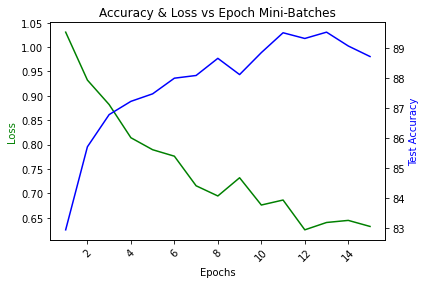

In [ ]:
import matplotlib.pyplot as plt

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

#### **Early Stopping in PyTorch**

https://github.com/Bjarten/early-stopping-pytorch